In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
print(f'torch version: {torch.__version__}')

#Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

torch version: 1.13.0+cpu
using device: cpu


In [2]:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
print(data.shape)
data.head()

np.random.seed(3)
torch.manual_seed(3)
torch.cuda.manual_seed(3)

raw_numpy= data.to_numpy()
np.random.shuffle(raw_numpy)
raw_torch = torch.tensor(raw_numpy)
X = raw_torch[:, 1:].type(torch.float) / 255.
y = raw_torch[:, 0].type(torch.long)
print(f"X.shape: {X.shape}, y.shape, {y.shape}")
train_split = int(0.8*len(X))
X_train, X_test = X[:train_split], X[train_split:]
y_train, y_test = y[:train_split], y[train_split:]
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(42000, 785)
X.shape: torch.Size([42000, 784]), y.shape, torch.Size([42000])
torch.Size([33600, 784]) torch.Size([8400, 784]) torch.Size([33600]) torch.Size([8400])


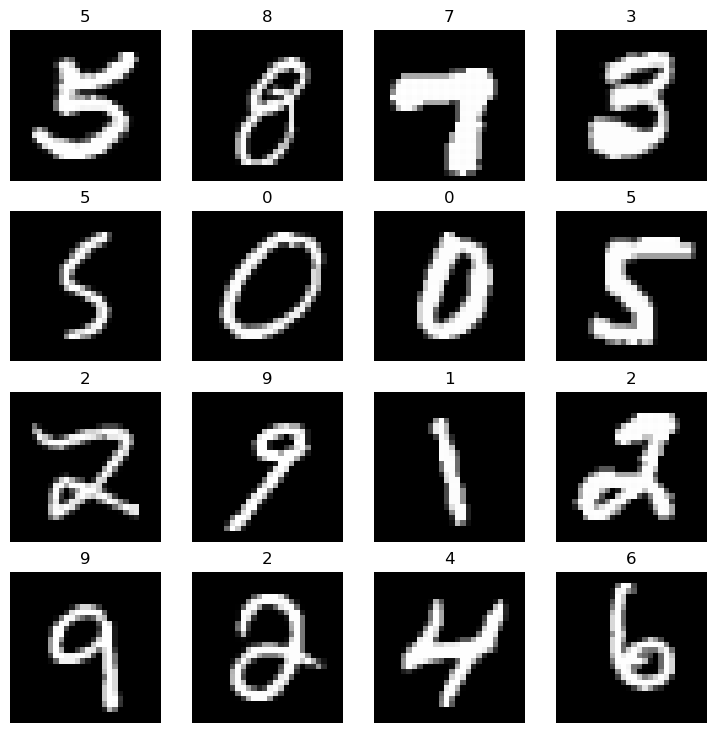

In [3]:
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1):
    random_idx = torch.randint(0, len(X_train), size = [1]).item()
    img  = torch.mul(X_train[random_idx].reshape((28, 28)), 255)
    label = y_train[random_idx].item()
    fig.add_subplot(rows, cols, i)
    plt.imshow(img, cmap = "gray")
    plt.title(label)
    plt.axis(False)

In [4]:

from torch.utils.data import Dataset, DataLoader
"""
Trigger warning :::
This is the worst implementation of a PyTorch Custom Dataset
you'll ever see lol
"""
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.data[idx]
        return [data, label]
        sample = {"Data": data, "Class": label}
        return sample
    
    
### Hyperparameters
BATCH_SIZE = 32

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)


train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle = True) #drop_last = True
test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE) #drop_last = True

print(f"Length of train_dataloader: {len(train_dataloader)} batches of size {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of size {BATCH_SIZE}")

train_features_batch, train_labels_batch = next(iter(train_dataloader))
test_features_batch, test_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape, train_labels_batch.shape)
print(test_features_batch.shape, test_labels_batch.shape)

Length of train_dataloader: 1050 batches of size 32
Length of test_dataloader: 263 batches of size 32
torch.Size([32, 784]) torch.Size([32])
torch.Size([32, 784]) torch.Size([32])


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"On device: {device}")

#Already "normalized" inputs to values 0-1
#nn.ReLU(), nn.Sigmoid(), nn.BatchNormalization(), nn.Dropout(0.25),
#Sceduler

class AudoencoderV0(nn.Module):
    def __init__(self,
                 hidden_units: int,
                 bottleneck: int):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(in_features=784,
                      out_features=hidden_units),
            nn.Linear(in_features = hidden_units,
                      out_features = bottleneck)
        )
        self.decoder = nn.Sequential(
            nn.Linear(in_features=bottleneck,
                      out_features=hidden_units),
            nn.Linear(in_features = hidden_units,
                      out_features = 784)
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.decoder(self.encoder(x))

model_0 = AudoencoderV0(hidden_units=50,
                            bottleneck=10).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)
model_0

On device: cpu


AudoencoderV0(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=784, bias=True)
  )
)

In [6]:
from tqdm.auto import tqdm #progress bar
epochs = 5
for epochs in range(epochs):
    for batch, (X, y) in tqdm(enumerate(train_dataloader)):
        X=X.to(device)
        model_0.train()
        #1. Forward pass
        y_pred = model_0(X)
        #2 Calculate loss (per batch)
        loss = loss_fn(y_pred, X)
        #3. Optimizer zero grad
        optimizer.zero_grad()
        #4. Loss backward
        loss.backward()
        #5. Optimizer step
        optimizer.step()
        if batch %100 == 0:
            model_0.eval()
            train_loss = 0
            test_loss = 0
            with torch.inference_mode(): #context manager
                for X_t, _ in train_dataloader:
                    X_t = X_t.to(device)
                    y_t_pred = model_0(X_t)
                    loss_t = loss_fn(y_t_pred, X_t)
                    train_loss+=loss_t #accumulate train loss
                for X_test, _ in test_dataloader:
                    X_test = X_test.to(device)
                    y_test_pred = model_0(X_test)
                    loss_test = loss_fn(y_test_pred, X_test)
                    test_loss+=loss_test #accumulate train loss

                train_loss /= len(train_dataloader)
                test_loss /= len(test_dataloader)
            print(f"Batch: {batch} | Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}")

0it [00:00, ?it/s]

Batch: 0 | Train loss: 0.1374 | Test loss: 0.1368
Batch: 100 | Train loss: 0.1212 | Test loss: 0.1206
Batch: 200 | Train loss: 0.1132 | Test loss: 0.1126
Batch: 300 | Train loss: 0.1071 | Test loss: 0.1066
Batch: 400 | Train loss: 0.1019 | Test loss: 0.1015
Batch: 500 | Train loss: 0.0972 | Test loss: 0.0968
Batch: 600 | Train loss: 0.0929 | Test loss: 0.0924
Batch: 700 | Train loss: 0.0886 | Test loss: 0.0882
Batch: 800 | Train loss: 0.0845 | Test loss: 0.0842
Batch: 900 | Train loss: 0.0809 | Test loss: 0.0806
Batch: 1000 | Train loss: 0.0774 | Test loss: 0.0771


0it [00:00, ?it/s]

Batch: 0 | Train loss: 0.0759 | Test loss: 0.0757
Batch: 100 | Train loss: 0.0733 | Test loss: 0.0731
Batch: 200 | Train loss: 0.0712 | Test loss: 0.0710
Batch: 300 | Train loss: 0.0695 | Test loss: 0.0693
Batch: 400 | Train loss: 0.0682 | Test loss: 0.0681
Batch: 500 | Train loss: 0.0672 | Test loss: 0.0671
Batch: 600 | Train loss: 0.0664 | Test loss: 0.0663
Batch: 700 | Train loss: 0.0659 | Test loss: 0.0658
Batch: 800 | Train loss: 0.0654 | Test loss: 0.0653
Batch: 900 | Train loss: 0.0651 | Test loss: 0.0650
Batch: 1000 | Train loss: 0.0649 | Test loss: 0.0648


0it [00:00, ?it/s]

Batch: 0 | Train loss: 0.0648 | Test loss: 0.0647
Batch: 100 | Train loss: 0.0646 | Test loss: 0.0645
Batch: 200 | Train loss: 0.0644 | Test loss: 0.0643
Batch: 300 | Train loss: 0.0643 | Test loss: 0.0642
Batch: 400 | Train loss: 0.0642 | Test loss: 0.0641
Batch: 500 | Train loss: 0.0641 | Test loss: 0.0640
Batch: 600 | Train loss: 0.0640 | Test loss: 0.0640
Batch: 700 | Train loss: 0.0640 | Test loss: 0.0639
Batch: 800 | Train loss: 0.0639 | Test loss: 0.0638
Batch: 900 | Train loss: 0.0638 | Test loss: 0.0638
Batch: 1000 | Train loss: 0.0638 | Test loss: 0.0637


0it [00:00, ?it/s]

Batch: 0 | Train loss: 0.0638 | Test loss: 0.0637
Batch: 100 | Train loss: 0.0637 | Test loss: 0.0636
Batch: 200 | Train loss: 0.0636 | Test loss: 0.0636
Batch: 300 | Train loss: 0.0636 | Test loss: 0.0635
Batch: 400 | Train loss: 0.0635 | Test loss: 0.0634
Batch: 500 | Train loss: 0.0635 | Test loss: 0.0634
Batch: 600 | Train loss: 0.0634 | Test loss: 0.0633
Batch: 700 | Train loss: 0.0634 | Test loss: 0.0633
Batch: 800 | Train loss: 0.0633 | Test loss: 0.0632
Batch: 900 | Train loss: 0.0633 | Test loss: 0.0632
Batch: 1000 | Train loss: 0.0632 | Test loss: 0.0631


0it [00:00, ?it/s]

Batch: 0 | Train loss: 0.0632 | Test loss: 0.0631
Batch: 100 | Train loss: 0.0631 | Test loss: 0.0630
Batch: 200 | Train loss: 0.0631 | Test loss: 0.0630
Batch: 300 | Train loss: 0.0630 | Test loss: 0.0629
Batch: 400 | Train loss: 0.0630 | Test loss: 0.0629
Batch: 500 | Train loss: 0.0629 | Test loss: 0.0628
Batch: 600 | Train loss: 0.0628 | Test loss: 0.0627
Batch: 700 | Train loss: 0.0628 | Test loss: 0.0627
Batch: 800 | Train loss: 0.0627 | Test loss: 0.0626
Batch: 900 | Train loss: 0.0627 | Test loss: 0.0626
Batch: 1000 | Train loss: 0.0626 | Test loss: 0.0625


In [10]:
X, y = next(iter(train_dataloader))
X.shape, y.shape

(torch.Size([32, 784]), torch.Size([32]))

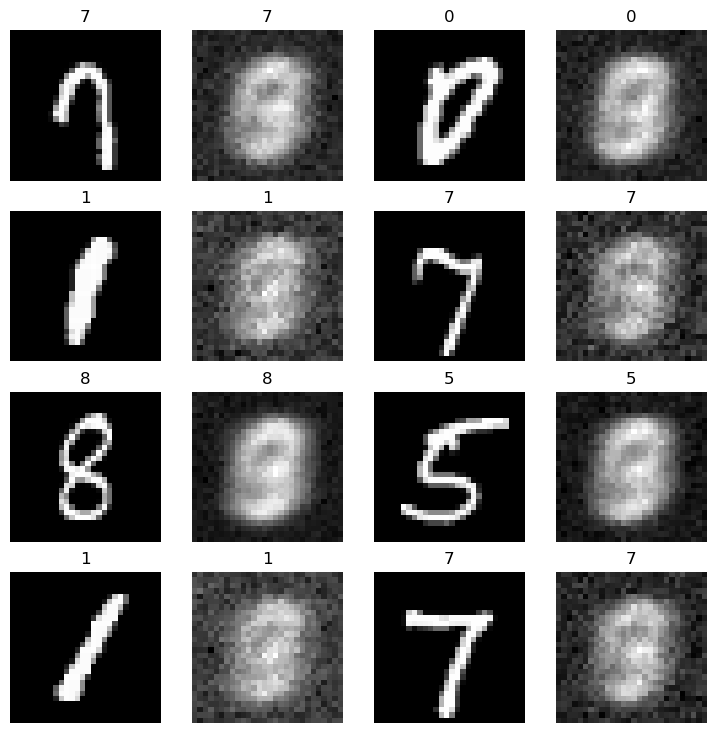

In [21]:
fig = plt.figure(figsize=(9,9))
rows, cols = 4, 4
for i in range(1, rows*cols+1, 2):
    cur = X[i]
    pred = model_0(cur)
    img_real =  torch.mul(cur.reshape((28, 28)), 255)
    img_pred = torch.mul(pred.reshape((28, 28)), 255)
    label = y[i].item()
    fig.add_subplot(rows, cols, i)
    plt.imshow(img_real.detach().numpy(), cmap = "gray")
    plt.title(label)
    plt.axis(False)
    
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(img_pred.detach().numpy(), cmap = "gray")
    plt.title(label)
    plt.axis(False)

<Figure size 640x480 with 0 Axes>